In [1]:
from PIL import Image
import json
import pandas as pd
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.dataloader import default_collate
import matplotlib.pyplot as plt
import numpy as np
import textwrap, os
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.PILToTensor()
])

In [2]:
n_imgs = 8192
IMG_FOLDER = '/kaggle/input/im2latex-230k/PRINTED_TEX_230k/generated_png_images/'
max_img_width = 300
max_img_height = 50
formula_pad_number = 579
max_formula_pad = 400

In [3]:
print("Running on: ")
if torch.cuda.is_available(): 
    dev = "cuda:0"
    print("Cuda")
else:
    dev = "cpu"
    print("CPU")
device = torch.device(dev) 
a = torch.zeros(4,3) 
a = a.to(device)

Running on: 
Cuda


In [4]:
with open('/kaggle/input/im2latex-230k/PRINTED_TEX_230k/230k.json') as file:
    json230k = json.load(file)
    file.close()
with open('/kaggle/input/im2latex-230k/PRINTED_TEX_230k/corresponding_png_images.txt') as file:
    img_files = [next(file).strip() for _ in range(n_imgs)]
    file.close()
with open('/kaggle/input/im2latex-230k/PRINTED_TEX_230k/final_png_formulas.txt') as file:
    formulas_raw = [next(file).strip().replace(' ','') for _ in range(n_imgs)]
    file.close()

In [5]:
def convertFormulaToTokens(formula_raw):
    formula = []
    while formula_raw != '':
        replaced = 0
        for key, value in json230k.items():
            if formula_raw.startswith(key):
                formula.append(int(value))
                formula_raw = formula_raw.removeprefix(key)
                replaced = 1
                exit
        if replaced == 0:
            print("potential key error")
            return formula
            #raise ValueError('Didnt find a key for '+formula_raw) 
    return formula

In [6]:
def convertTokensToFormula(formula):
    formula_raw = ''
    for idx, token in enumerate(formula):
        for key, value in json230k.items():
            if token == value:
                formula_raw = formula_raw + key
    return formula_raw

In [7]:
def load_and_transform_image(file):
    raw_img = Image.open(IMG_FOLDER + file).convert('L')
    img = Image.new(raw_img.mode, (max_img_width, max_img_height), "white")
    img.paste(raw_img, (0, 0))
    return img
    

In [8]:
data = torch.stack([transform(load_and_transform_image(img))/256 for img in img_files]).to(device)
labels_without_padding = [torch.tensor(convertFormulaToTokens(f)).float() for f in formulas_raw]
labels = torch.stack([nn.functional.pad(x, pad=(0, max_formula_pad - len(x)), mode='constant', value=formula_pad_number) for x in labels_without_padding]).to(device)

potential key error
potential key error
potential key error
potential key error


In [9]:
data.shape

torch.Size([8192, 1, 50, 300])

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.block1 = nn.Sequential(
            nn.LazyConv2d(20, kernel_size=5),
            nn.GELU(),
            nn.LazyConv2d(10, kernel_size=5),
            nn.GELU(),
            nn.Dropout(),
            nn.LazyConv2d(20, kernel_size=5),
            nn.GELU(),
            nn.LazyBatchNorm2d()
        )
        self.block2 = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(1000),
            nn.GELU(),
            nn.Dropout(),
            nn.LazyLinear(1000),
            nn.GELU(),
            nn.LazyLinear(max_formula_pad)
        )
    
    def forward(self, x):
        out = x
        out = self.block1(out)
        out = self.block2(out)
        return out

In [11]:
n_epochs = 10
batch_size_train = 64
learning_rate = 3e-4
momentum = 0.8
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [12]:
network = Net()
network.to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [13]:
train_loader = DataLoader(torch.utils.data.TensorDataset(data, labels), batch_size=batch_size_train, shuffle=True)

In [14]:
train_losses = []
train_counter = []
test_losses = []
test_counter = []

In [15]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()
            ))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset))
            )
            torch.save(network.state_dict(), '/kaggle/working/model.pth')
            torch.save(optimizer.state_dict(), '/kaggle/working/optimizer.pth')

In [16]:
for epoch in range(1,n_epochs+1):
    train(epoch)


Train Epoch: 1 [0/8192 (0%)]	Loss: 308483.312500
Train Epoch: 1 [640/8192 (8%)]	Loss: 229372.953125
Train Epoch: 1 [1280/8192 (16%)]	Loss: 55073.867188
Train Epoch: 1 [1920/8192 (23%)]	Loss: 35771.800781
Train Epoch: 1 [2560/8192 (31%)]	Loss: 41402.589844
Train Epoch: 1 [3200/8192 (39%)]	Loss: 26258.984375
Train Epoch: 1 [3840/8192 (47%)]	Loss: 26251.396484
Train Epoch: 1 [4480/8192 (55%)]	Loss: 24083.445312
Train Epoch: 1 [5120/8192 (62%)]	Loss: 21970.855469
Train Epoch: 1 [5760/8192 (70%)]	Loss: 22866.593750
Train Epoch: 1 [6400/8192 (78%)]	Loss: 20078.335938
Train Epoch: 1 [7040/8192 (86%)]	Loss: 23846.554688
Train Epoch: 1 [7680/8192 (94%)]	Loss: 19042.662109
Train Epoch: 2 [0/8192 (0%)]	Loss: 21900.519531
Train Epoch: 2 [640/8192 (8%)]	Loss: 20130.787109
Train Epoch: 2 [1280/8192 (16%)]	Loss: 22241.628906
Train Epoch: 2 [1920/8192 (23%)]	Loss: 19913.730469
Train Epoch: 2 [2560/8192 (31%)]	Loss: 17778.085938
Train Epoch: 2 [3200/8192 (39%)]	Loss: 24243.673828
Train Epoch: 2 [3840/8

Text(0, 0.5, 'negative log likelihood loss')

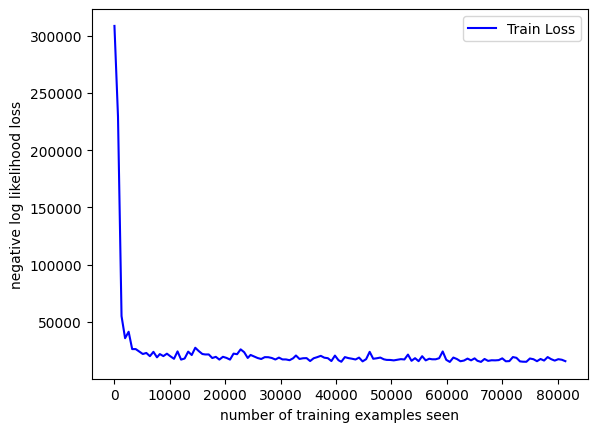

In [17]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')